# Проект: классификация

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Загрузка данных

In [185]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [187]:
# Посмотрим на количество пропусков в признаке balance
df.balance.isnull().sum()

25

#### Посмотрим какие сферы деятельности клиентов задействованы в датасете

In [188]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [189]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].astype(float)

In [190]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes


#### Пропуски могут быть неочевидными, завуалированы словом или символом, посредством визуального знаковства с данными, можно увидеть, что в признаках job и education есть значения 'unknown', обработаем пропуски в этих признаках

In [191]:
# обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку
df.balance.fillna(df.balance.median(), inplace=True)


Посмотрим на средний баланс по выборке

In [192]:
print(round(df.balance.mean(), 3))

1526.936


In [193]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_moda = df.job.mode()[0]
df.job = df.job.apply(lambda x: job_moda if x == 'unknown' else x)

In [194]:
edu_moda = df.education.mode()[0]
df.education = df.education.apply(lambda x: edu_moda if x=='unknown' else x)

После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 

In [195]:
print(round(df[(df.job == job_moda) & (df.education == edu_moda)]['balance'].mean(), 3))


1598.883


### Работа с выбросами. Напишем функцию для обработки выбросов по методу Тьюки:

In [197]:
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха.
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
        lower_bound, upper_bound: нижняя и верхняя границы, определяющие выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

df_outliers, df_cleand, lower_bound, upper_bound = find_outliers_iqr(df, 'balance')

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')
print(f'Оставшееся количество объектов после удаления выбросов: {df_cleand.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Оставшееся количество объектов после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Посмотрим на распределение целевой переменной deposit 

no     5424
yes    4681
Name: deposit, dtype: int64

<AxesSubplot: xlabel='deposit', ylabel='count'>

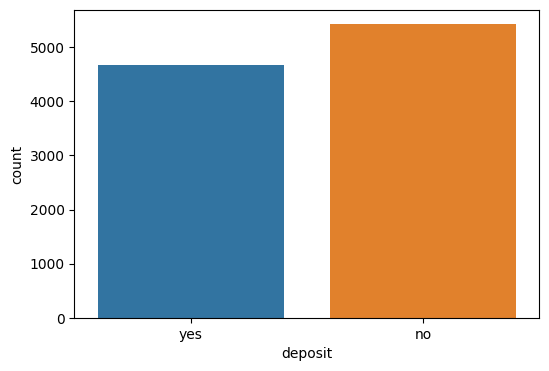

In [201]:
display(df_cleand.deposit.value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='deposit', data=df_cleand)

Распределение нормальное 

In [202]:
#рассчитаем описательные статистики для количественных переменных
df_cleand.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'balance'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>,
        <AxesSubplot: title={'center': 'pdays'}>],
       [<AxesSubplot: title={'center': 'previous'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

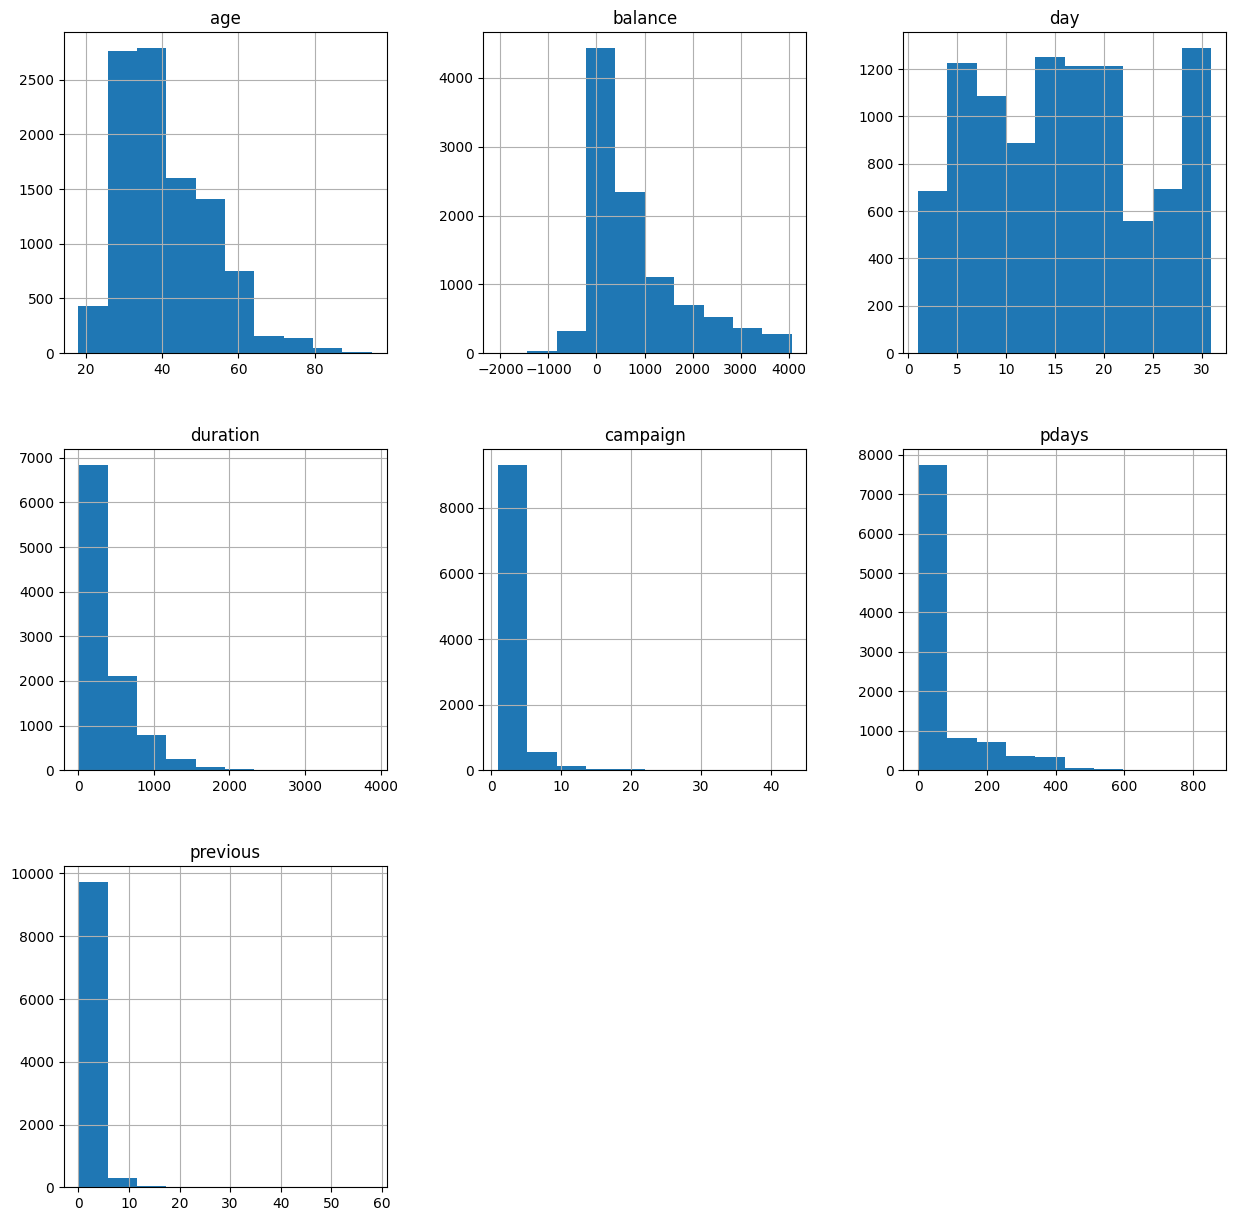

In [203]:
# Посмотрим на распределение числовых признаков.
df_cleand.hist(figsize = (15,15))

In [204]:
#рассчитаем описательные статистики для категориальных переменных
df_cleand.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


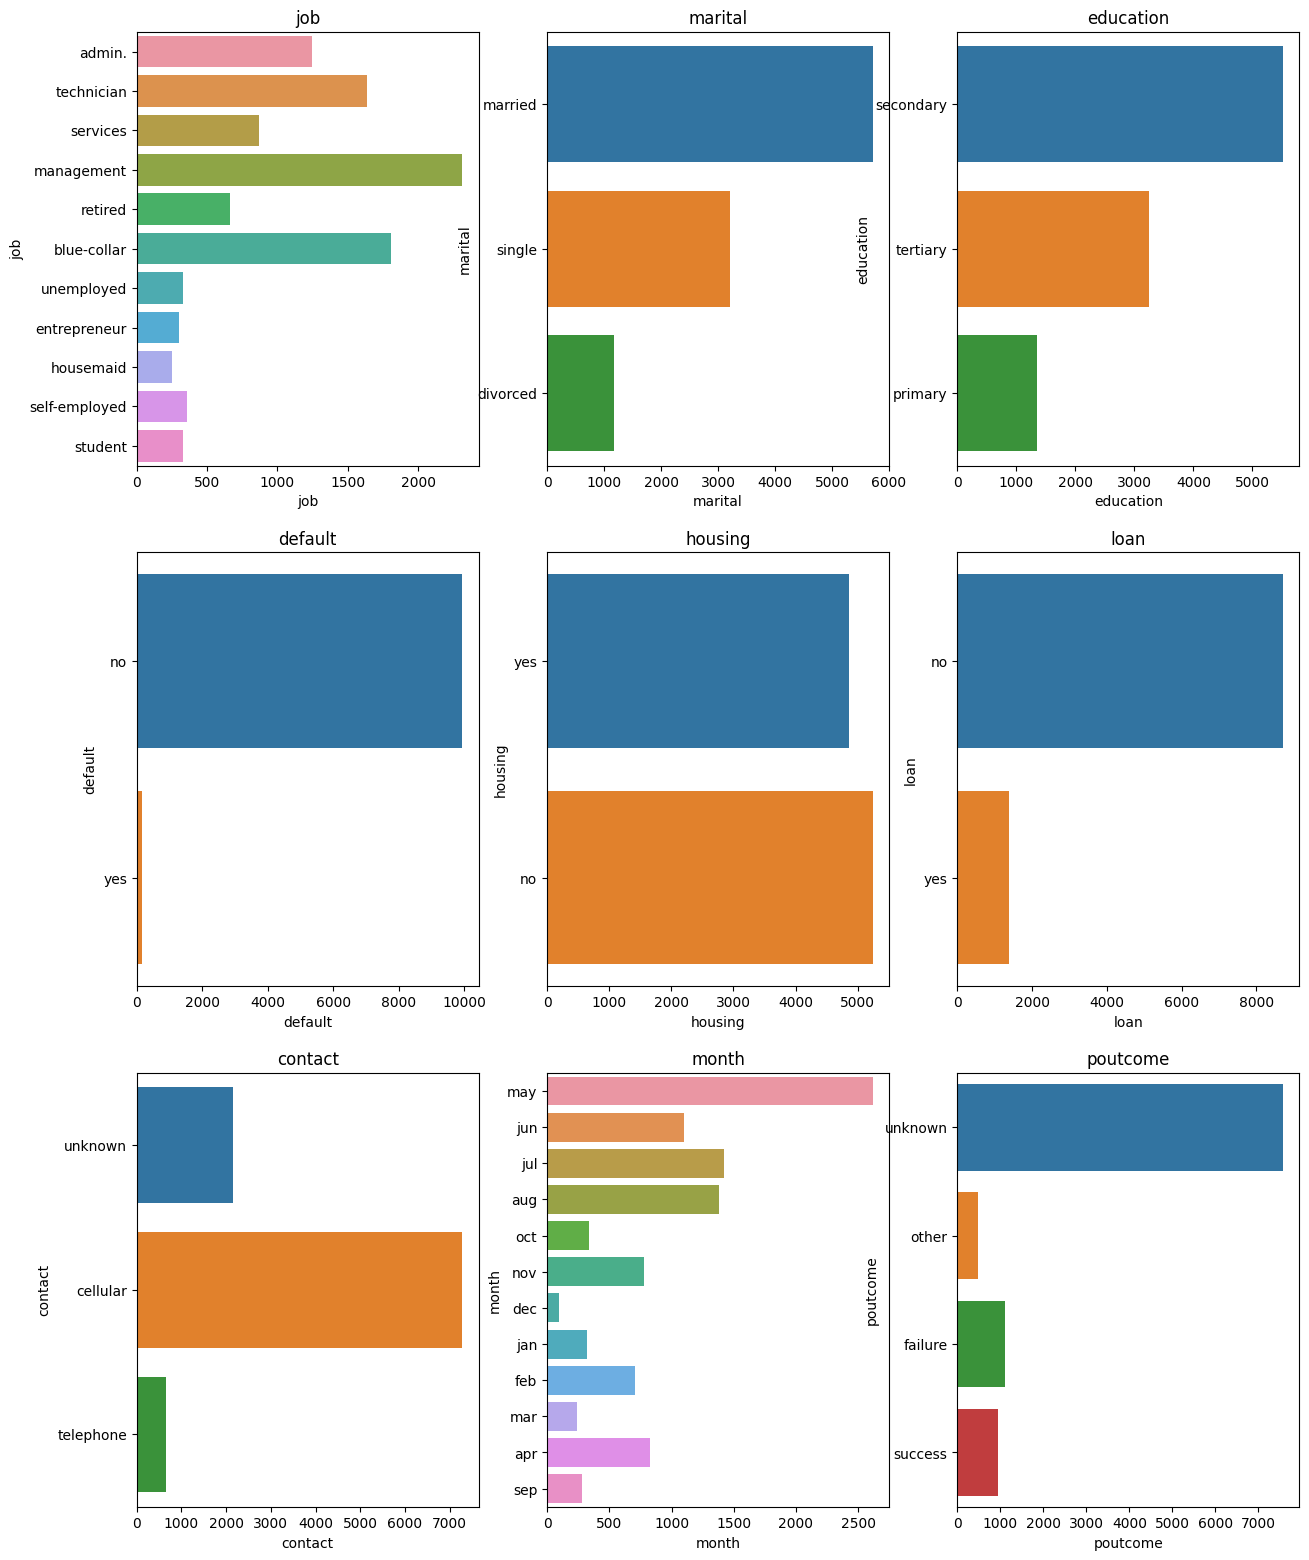

In [207]:
# Посмотрим на распределение категориальных признаков.
df.describe(include = 'object')
categorical_features=[feature for feature in df_cleand.columns if ((df_cleand[feature].dtypes=='O') & (feature not in ['deposit']))]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df_cleand)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1

plt.show()

In [208]:
df_cleand.month.value_counts()

may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: month, dtype: int64

<AxesSubplot: xlabel='job', ylabel='count'>

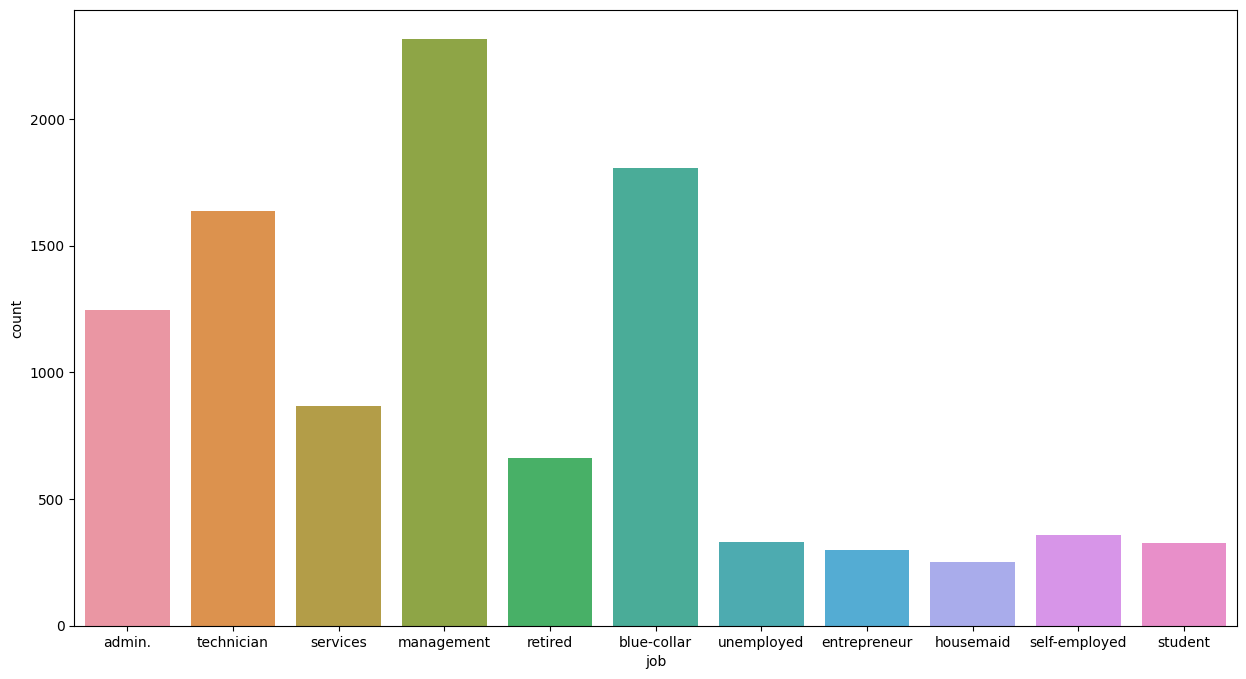

In [214]:
# Посмотрим на количество клиентов по разным сферам деятельности:
plt.rcParams['figure.figsize'] = (15,8)
sns.countplot(x='job', data=df_cleand)

In [210]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_cleand.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Распределение статуса предидущей маркетинговой кампании в разрезе успеха нынешней')

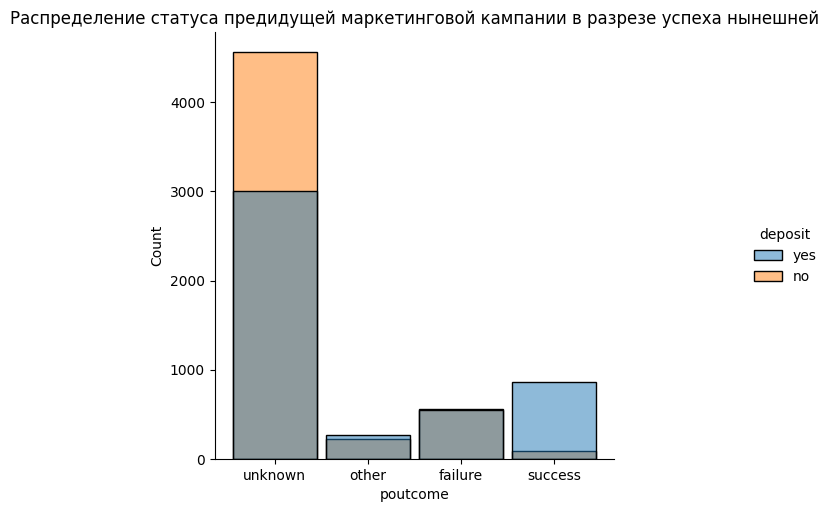

In [66]:
pout_hist = sns.displot(df_cleand, x='poutcome', shrink=.9, hue='deposit')
pout_hist.ax.set_title('Распределение статуса предыдущей маркетинговой кампании в разрезе успеха нынешней')

Количество открытых депозитов превалирует для статуса успешной прошедшей маркетинговой компании.

In [224]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
df_cleand.groupby('month')['deposit'].value_counts()

month  deposit
apr    yes         513
       no          317
aug    no          775
       yes         610
dec    yes          84
       no            9
feb    yes         386
       no          323
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    yes         213
       no           24
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    yes         273
       no           62
sep    yes         232
       no           46
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Распределение month для отказов от открытия депозита')

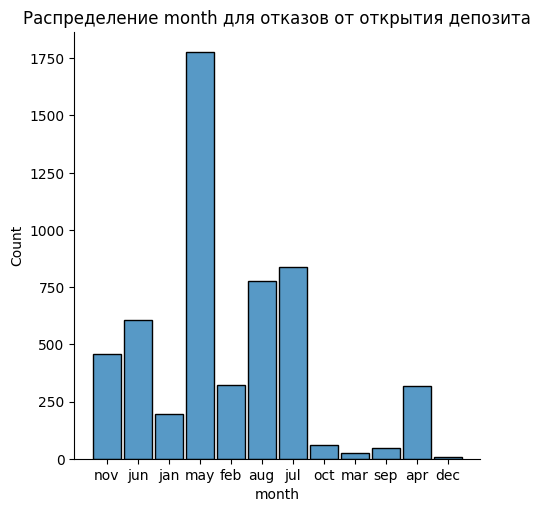

In [69]:
mon_hist = sns.displot(df_cleand[df_cleand['deposit'] == 'no'], x='month', shrink=.9)
mon_hist.ax.set_title('Распределение month для отказов от открытия депозита')

В мае больше всего отказов по открытию депозита, возможно этот месяц не подходит для проведения новой маркетинговой компании.

In [225]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

df_cleand['age_group'] = df_cleand['age'].apply(age_group)



Text(0.5, 1.0, 'Распределение возрастных групп в разрезе открытия депозита')

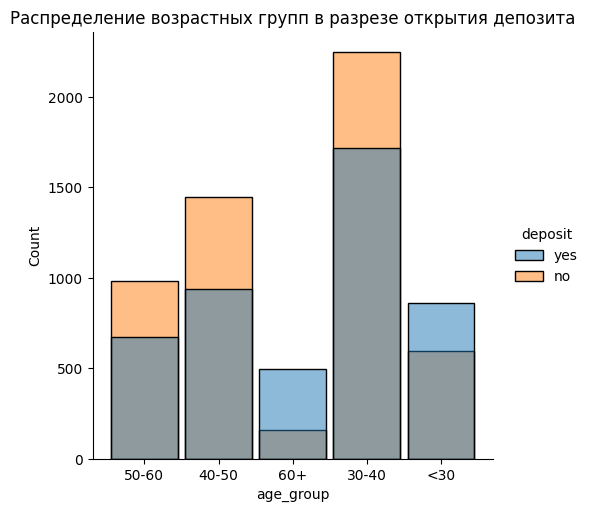

In [226]:
group_hist = sns.displot(df_cleand, x='age_group', shrink=.9, hue='deposit')
group_hist.ax.set_title('Распределение возрастных групп в разрезе открытия депозита')

Text(0.5, 1.0, 'Распределение семейного статуса клиентов в разрезе открытия депозита')

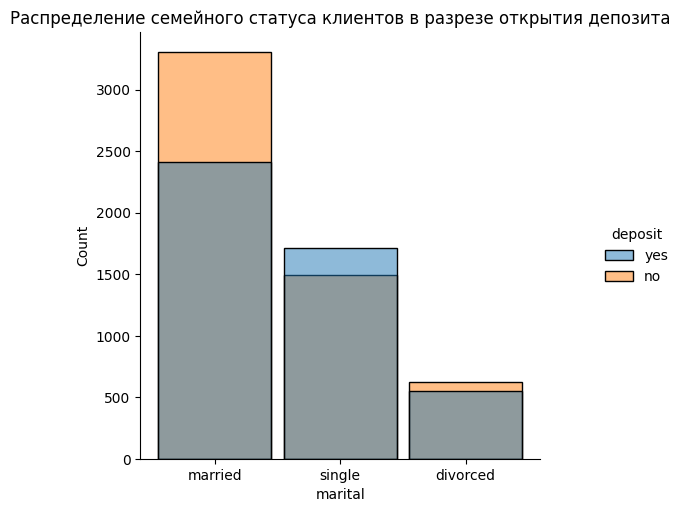

In [227]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
group_hist = sns.displot(df_cleand, x='marital', shrink=.9, hue='deposit')
group_hist.ax.set_title('Распределение семейного статуса клиентов в разрезе открытия депозита')

Text(0.5, 1.0, 'Распределение уровня образования в разрезе открытия депозита')

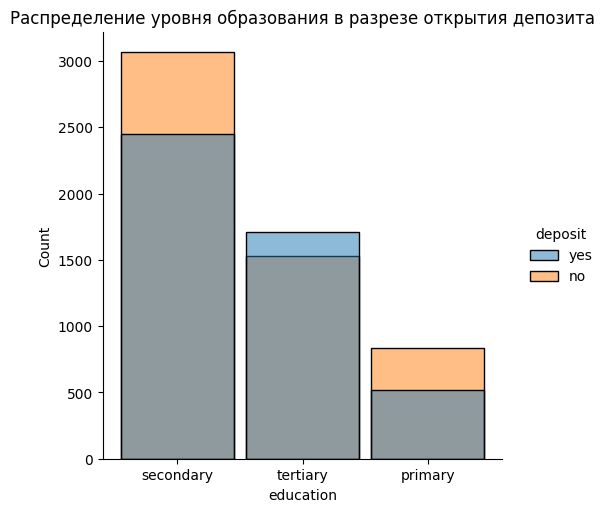

In [89]:
# построем визуализации для открывших и неоткрывших депозит в зависимости от образования
group_hist = sns.displot(df_cleand, x='education', shrink=.9, hue='deposit')
group_hist.ax.set_title('Распределение уровня образования в разрезе открытия депозита')

Text(0.5, 1.0, 'Распределение профессиональных сфер занятости в разрезе открытия депозита')

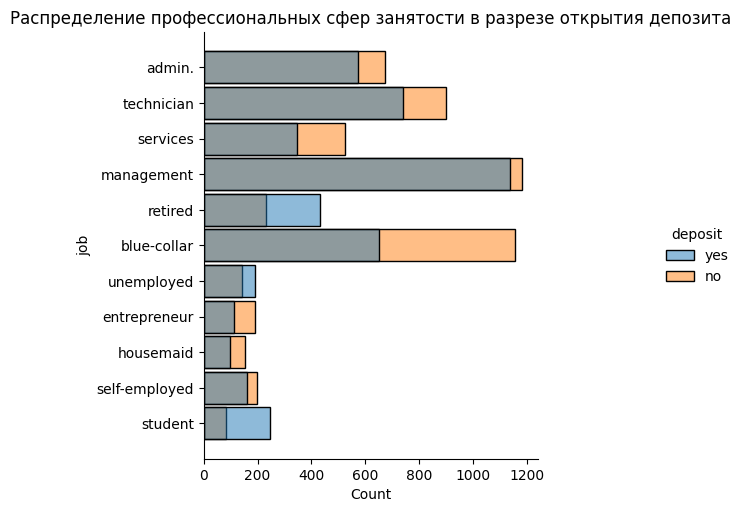

In [228]:
# построем визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
group_hist = sns.displot(df_cleand, y='job', shrink=.9, hue='deposit')
group_hist.ax.set_title('Распределение профессиональных сфер занятости в разрезе открытия депозита')

In [99]:
# построимсводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_yes = pd.pivot_table(
    data=df_cleand[df_cleand['deposit']=='yes'],
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'
)
pivot_yes

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


Видим, что по признакам семейного положения и уровню образования, наиболее лояльные клиенты, открывшие депозит - это категория клиентов, у которых семейное положение 'maried' и уровнем образования 'secondary'

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построем сводную диаграмму по уровню образования и семейному положению. Представим результаты в виде тепловых карт. 

In [97]:
yes_deposit_data = df_cleand[df_cleand['deposit']=='yes']
no_deposit_data = df_cleand[df_cleand['deposit']=='no']

In [100]:
# построем сводную таблицу для клиентов, не открывших депозит, по признакам семейного положения и уровню образования
pivot_no = pd.pivot_table(
    data=df_cleand[df_cleand['deposit']=='no'],
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'
)
pivot_no

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


<AxesSubplot: xlabel='marital', ylabel='education'>

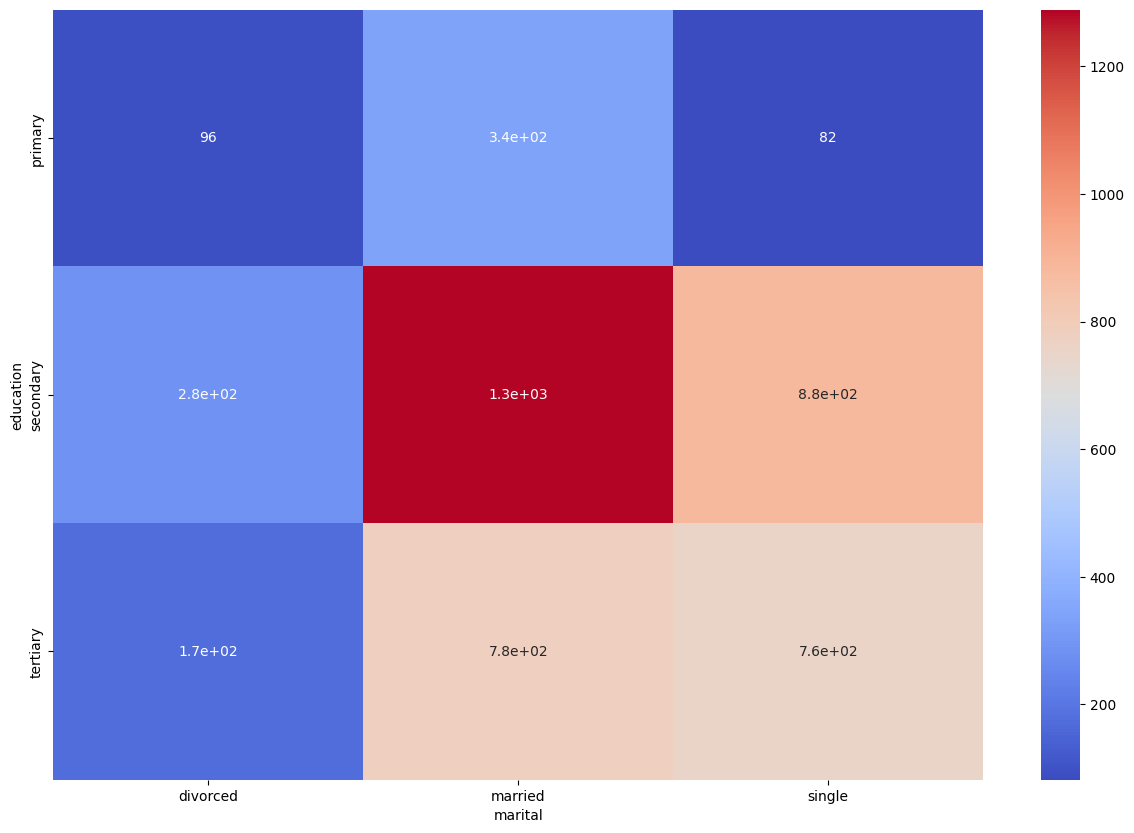

In [104]:
# Теловая карта по клиентам, открывшим депозит
sns.heatmap(pivot_yes, annot=True, cmap='coolwarm')

<AxesSubplot: xlabel='marital', ylabel='education'>

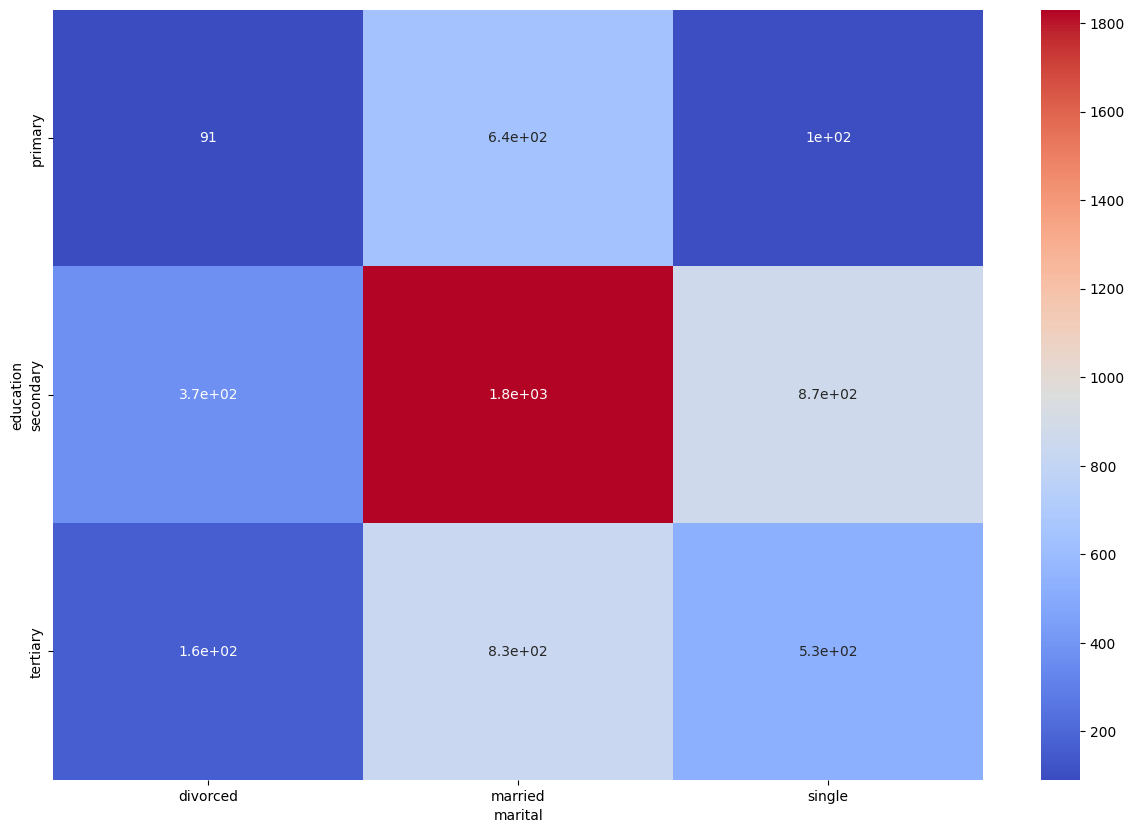

In [105]:
# Теловая карта по клиентам, не открывшим депозит
sns.heatmap(pivot_no, annot=True, cmap='coolwarm')

## Часть 3: преобразование данных

In [229]:
# преобразуем уровни образования
lab_enc = LabelEncoder()

# Кодирование признака
df_cleand['education'] = lab_enc.fit_transform(df_cleand['education'])
df_cleand['education'].sum()

11995

In [230]:
# преобразуем признак по возрастной группе
lab_enc = LabelEncoder()

# Кодирование признака
df_cleand['age_group'] = lab_enc.fit_transform(df_cleand['age_group'])


### Задания 2 и 3

In [231]:
# преобразуем бинарные переменные в представление из нулей и единиц
df_cleand['deposit'] = df_cleand['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['default'] = df_cleand['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['housing'] = df_cleand['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['loan'] = df_cleand['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [232]:
#Посмотрим на стандартное отклонение
round(df_cleand['deposit'].std(), 3)

0.499

In [233]:
# создадим дамми-переменные
df_cleand = pd.get_dummies(df_cleand, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [234]:
df_cleand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Text(0.5, 0.98, 'Корреляционная матрица')

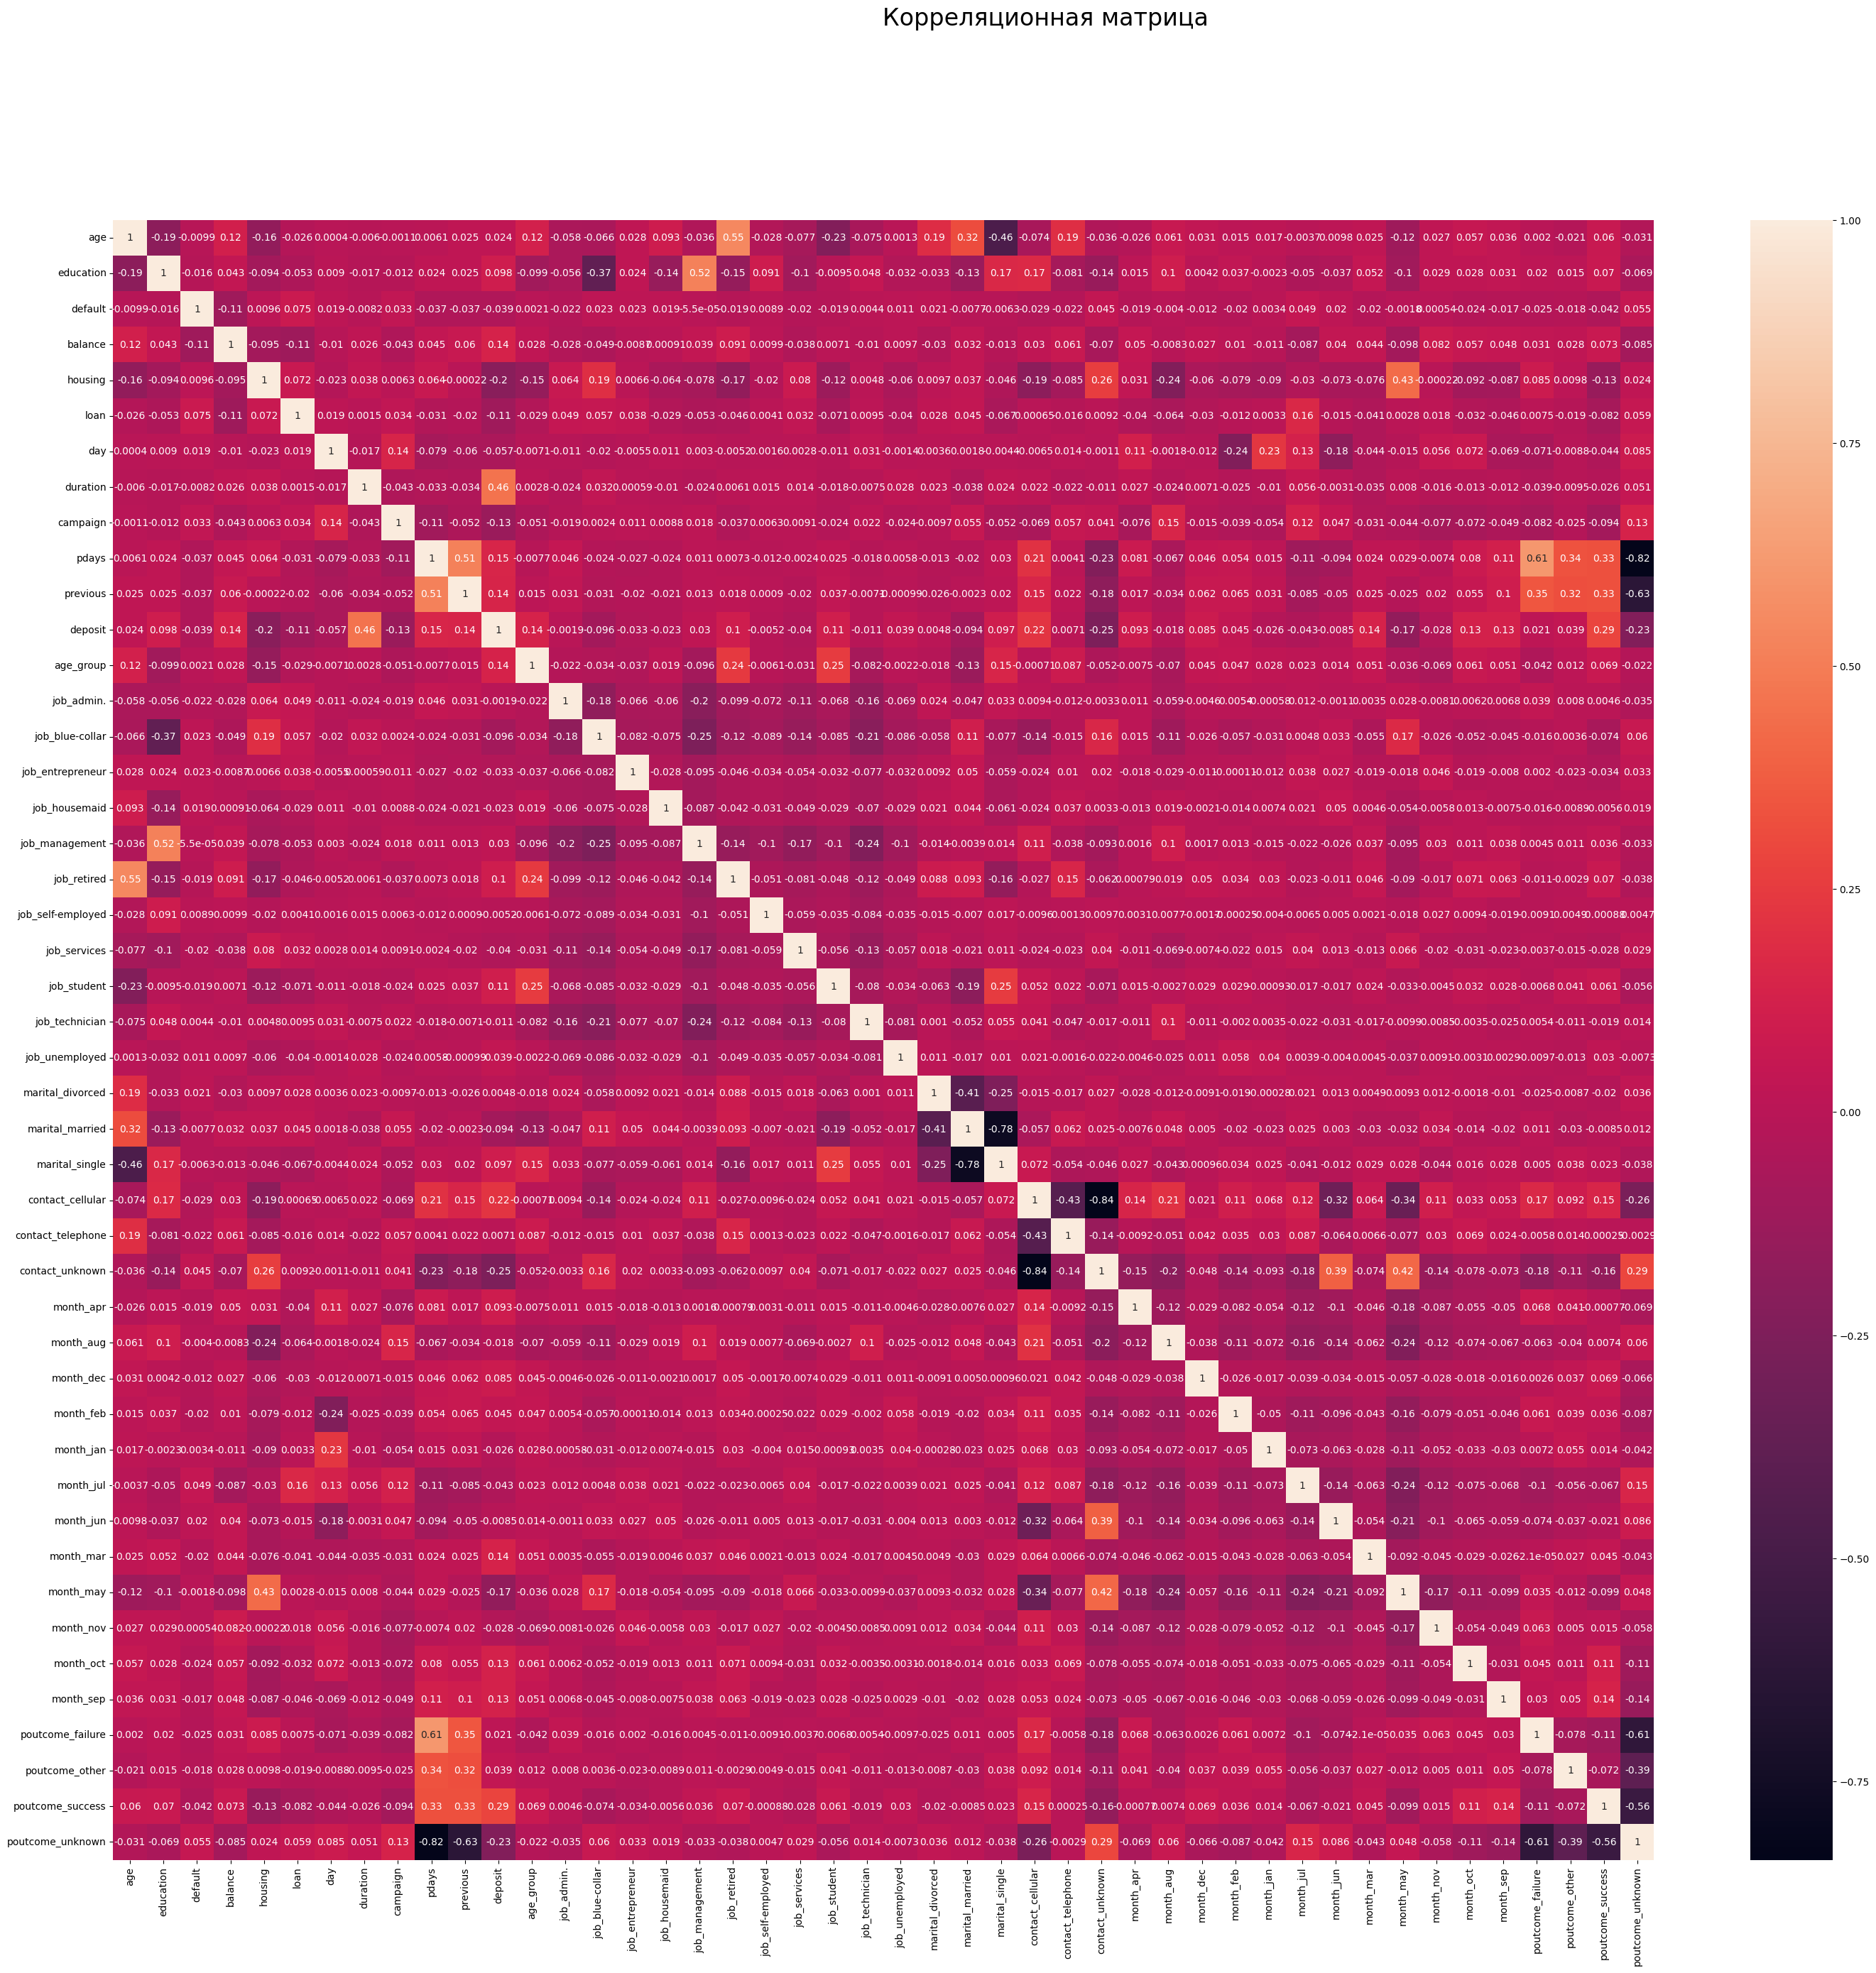

In [235]:
# построем корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (35,30))
heat_corr = sns.heatmap(df_cleand.corr(), annot=True)
heat_corr.figure.suptitle(
    'Корреляционная матрица', 
    fontsize=24)


In [121]:
corr = df_cleand.corr()
new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


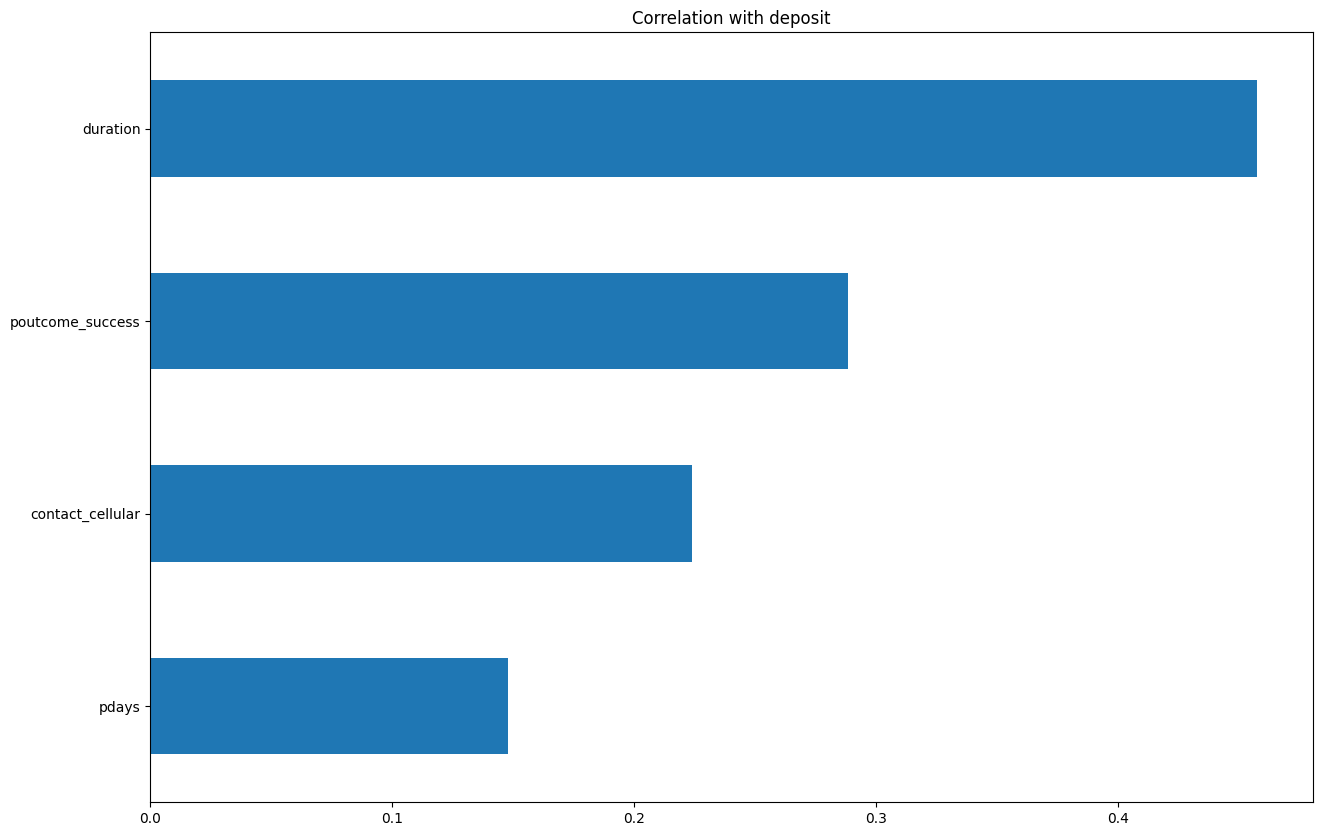

In [123]:
# строим столбчатую диаграмму наиболее скоррелированных признаков
corr = df_cleand.corr()

corr["deposit"].sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit")
plt.show()

In [236]:
# Разделим данные на тренировочную и тестовую выборки
X = df_cleand.drop(['deposit'], axis=1)
y = df_cleand['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [237]:
X_test.shape

(3335, 45)

In [238]:
round(y_test.mean(), 2)

0.46

In [239]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
best_f = SelectKBest(k=15)
best_f.fit(X_train, y_train)
X_train_fs = best_f.transform(X_train)
X_test_fs = best_f.transform(X_test)

# выведем 15 отобранных признаков
selected_features = best_f.get_feature_names_out()
print(selected_features)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [240]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_fs)
X_train_scaled = scaler.transform(X_train_fs)
X_test_scaled = scaler.transform(X_test_fs)

print(X_test_scaled[:, 0].mean())

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [242]:
# обучим логистическую регрессию и рассчитаем метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


In [244]:
# обучим решающие деревья
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    #min_samples_leaf=5,
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


Train: 0.82
Test: 0.81


In [245]:
# подберем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7], 
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42, #генератор случайных чисел
        #max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))


CPU times: user 321 ms, sys: 155 ms, total: 476 ms
Wall time: 9.05 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [246]:
# обучим на данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Test accuracy: 0.83
Test recall: 0.83


In [249]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
# Создаем модель градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb = GradientBoostingClassifier(
    min_samples_leaf=5, #количество листьев
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))
print('Test f1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test f1 score: 0.82


Градиентный бустинг не показал лучшего результата

In [250]:
# объединим уже известные алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        #min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42
        )),
    ('gb', ensemble.GradientBoostingClassifier(
        min_samples_leaf=5, #количество листьев
        learning_rate=0.05, #темп обучения
        n_estimators=300, #число деревьев
        max_depth=5, #максимальная глубина дерева
        random_state=42 #генератор случайных чисел
        ))
]

# Создаем объект класса стекинг
stack_reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
clf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
    ),
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)
y_pred_reg = clf.predict(X_test_scaled)

print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_pred_reg)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Text(0, 0.5, 'Признаки')

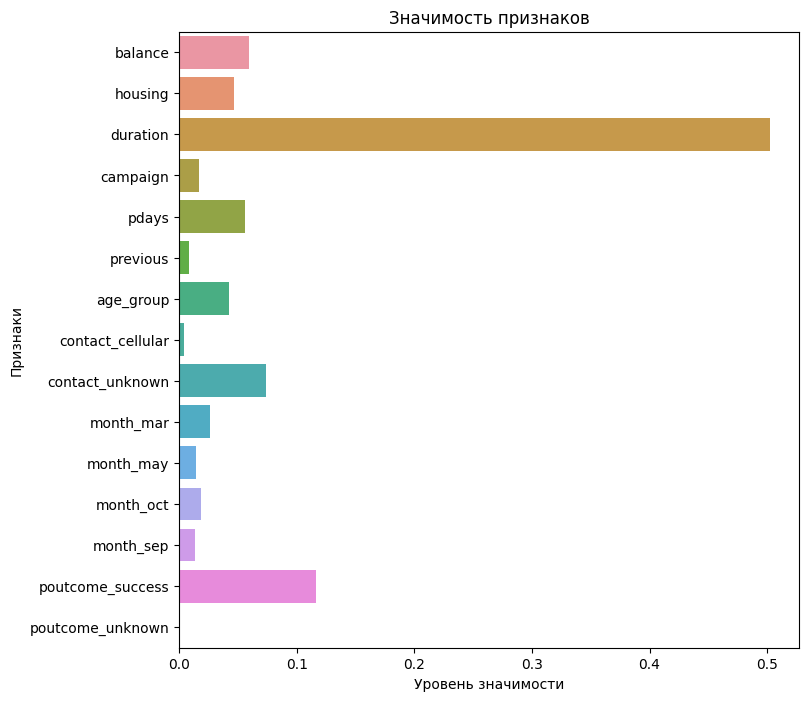

In [251]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
line,ax = plt.subplots(figsize=(8,8))
sns.barplot(x=gb.feature_importances_, y=selected_features)
ax.set_title('Значимость признаков', fontsize=12)
ax.set_xlabel ('Уровень значимости')
ax.set_ylabel ('Признаки')

Наибольшую важность демонстрируют признаки: duration, poutcome_sucsess, contact_unknown

In [252]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  model.fit(X_train_scaled, y_train)
  
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score


study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))



[I 2023-08-17 16:03:01,986] A new study created in memory with name: RandomForestClassifier
[I 2023-08-17 16:03:04,163] Trial 0 finished with value: 0.9036201222378938 and parameters: {'n_estimators': 196, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9036201222378938.
[I 2023-08-17 16:03:05,150] Trial 1 finished with value: 0.8674812030075187 and parameters: {'n_estimators': 139, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9036201222378938.
[I 2023-08-17 16:03:05,858] Trial 2 finished with value: 0.860012554927809 and parameters: {'n_estimators': 101, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9036201222378938.
[I 2023-08-17 16:03:06,972] Trial 3 finished with value: 0.878764237790607 and parameters: {'n_estimators': 153, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9036201222378938.
[I 2023-08-17 16:03:08,953] Trial 4 finished with value: 0.9252233892459633 and parameters: {'n_es

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.82


In [253]:
print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_test_pred)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335

